# data load

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import GRU, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D, AveragePooling1D, Average, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/train.csv")
test =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/test.csv")
test_labels =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/test_labels.csv")
submission =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [7]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [8]:
print(train.shape)
print(test.shape)
print(test_labels.shape)
print(submission.shape)

(159571, 8)
(153164, 2)
(153164, 7)
(153164, 7)


In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [10]:
train_x = train['comment_text']
test_x = test['comment_text']
train_y = train[labels].values

In [11]:
print('훈련용 코멘트 : {}'.format(len(train_x)))
print('테스트용 코멘트 : {}'.format(len(test_x)))
num_classes = 6
print('카테고리 : {}'.format(num_classes))

훈련용 코멘트 : 159571
테스트용 코멘트 : 153164
카테고리 : 6


In [12]:
train_x[:10]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [13]:
train_y[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# eda

In [14]:
train_length = train_x.apply(len)
train_length.head()

0    264
1    112
2    233
3    622
4     67
Name: comment_text, dtype: int64

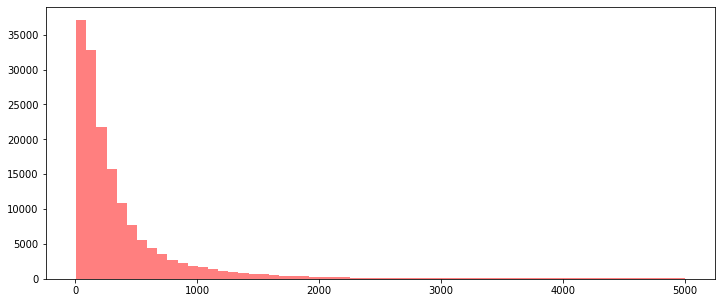

In [15]:
plt.figure(figsize = (12, 5))
plt.hist(train_length, bins = 60, alpha = 0.5, color = 'r')
plt.show()

In [16]:
print("max length : ", np.max(train_length))
print("min length : ", np.min(train_length))
print("mean length : ", np.mean(train_length))
print("75 % percentile : ", np.percentile(train_length, 75))
print("85 % percentile : ", np.percentile(train_length, 85))
print("std length : ", np.std(train_length))

max length :  5000
min length :  6
mean length :  394.0732213246768
75 % percentile :  435.0
85 % percentile :  663.0
std length :  590.7184309382149


In [17]:
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

# data preprocessing

## cleansing with re (1)

punctuation과 의미 없는 어휘들 제거

  ex) https 주소, 띄어쓰기 겹쳐있는 것, 숫자들(이거는 고민을 좀 했는데 날짜나 시간이 굳이 필요할까 싶어)

In [18]:
train_x = list(train_x)

string 클래스에 punctuation들이 다 포함되어 있는 모듈이 있어 저번처럼 노가다로 처리하지 않아도 된다는 소식^^

In [19]:
import string

result = string.punctuation
print(result)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [20]:
def clean_text(text):
    output = ""
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    for word in text:
      output = output + "" + word
    return str(output.strip())

In [21]:
train_texts = [] 

for line in tqdm(train_x, total=train.shape[0]): 
    train_texts.append(clean_text(line))

100%|██████████| 159571/159571 [00:21<00:00, 7476.46it/s]


In [22]:
print('Original data:', train_x[1], train_y[1])
print('Length of original data:', len(train_x[1]))
print('Cleaned data:', train_texts[1], train_y[1])
print('Length of cleaned data:', len(train_texts[1]))

Original data: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) [0 0 0 0 0 0]
Length of original data: 112
Cleaned data: daww he matches this background colour im seemingly stuck with thanks  talk  january   utc [0 0 0 0 0 0]
Length of cleaned data: 90


## cleansing with re (2)

소윤님의 abbreviation 처리를 가져왔습니다!

다만 저는 위에서 punctuation 처리를 다 해버리는 바람에 따옴표는 생략해줬어요.

In [23]:
def clean_text_ab(text):
    output = ""
    text = re.sub(r"its\s","it is",text) 
    text = re.sub(r"arent","are not",text)
    text = re.sub(r"couldnt","could not",text)
    text = re.sub(r"didnt","did not",text)
    text = re.sub(r"doesnt","does not",text)
    text = re.sub(r"dont","do not",text)
    text = re.sub(r"hadnt","had not",text)
    text = re.sub(r"hasnt","has not",text)
    text = re.sub(r"havent","have not",text)
    text = re.sub(r"isnt","is not",text)

    text = re.sub(r"mustnt","must not",text)
    text = re.sub(r"shadnt","shall not",text)
    text = re.sub(r"werent","were not",text)
    text = re.sub(r"wheres","where is",text)
    text = re.sub(r"whod","who would",text)
    text = re.sub(r"wont","will not",text)
    text = re.sub(r"wouldnt","would not",text)
    text = re.sub(r"whats", "what is", text)

    text = re.sub(r"\ve", " have", text)
    text = re.sub(r"cant", "can not", text)
    text = re.sub(r"lets","let us",text)
    text = re.sub(r"mightnt","might not",text)
    text = re.sub(r"im", "i am", text)
    for word in text:
      output = output + "" + word
    return str(output)

In [24]:
train_x = [] 

for line in tqdm(train_texts, total=train.shape[0]): 
    train_x.append(clean_text_ab(line))

100%|██████████| 159571/159571 [00:12<00:00, 12437.13it/s]


In [25]:
print('1st step cleaned data:', train_texts[1], train_y[1])
print('Length of 1st step cleaned data:', len(train_texts[1]))
print('Final cleaned data:', train_x[1], train_y[1])
print('Length of final cleaned data:', len(train_x[1]))

1st step cleaned data: daww he matches this background colour im seemingly stuck with thanks  talk  january   utc [0 0 0 0 0 0]
Length of 1st step cleaned data: 90
Final cleaned data: daww he matches this background colour i am seemingly stuck with thanks  talk  january   utc [0 0 0 0 0 0]
Length of final cleaned data: 92


## tokenize

In [26]:
maxlen = 250
max_words = 30000
embedding_dim = 100

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer on the comments 
tokenizer.fit_on_texts(train_x)

# Get the word index of the top 20000 words from the dataset
word_idx_og = tokenizer.word_index

# Convert the string sentence to a sequence of their numerical values
sequences = tokenizer.texts_to_sequences(train_x)

# Pad the sequences to make them of uniform length
padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = 'post')

In [28]:
print('Vocabulary size:', len(word_idx_og))
print("\nThe tokenized sequence:\n")
print(sequences[1])
print("\nThe padded sequence:\n")
print(padded_sequences[1])

Vocabulary size: 271284

The tokenized sequence:

[54, 2454, 14, 1391, 3549, 3, 27, 4199, 2486, 22, 100, 46, 899, 313]

The padded sequence:

[  54 2454   14 1391 3549    3   27 4199 2486   22  100   46  899  313
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [29]:
print('Shape of data tensor:', padded_sequences.shape)
print('Shape of label tensor:', train_y.shape)

Shape of data tensor: (159571, 250)
Shape of label tensor: (159571, 6)


In [30]:
# Shuffling data
indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(indices)
train_x = padded_sequences[indices]
train_y = train_y[indices]

In [31]:
print('Tokenized random sentences: \n', train_x[1])
print('One hot label: \n', train_y[1])

Tokenized random sentences: 
 [  64 6005  231    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

## GloVe

In [32]:
from numpy import array, asarray, zeros

embeddings_dictionary = {}

glove_file = open('/content/drive/MyDrive/Parrot_teamproject/glove.6B.100d.txt.zip (Unzipped Files)/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

print('Found %s numbers of vector' % len(embeddings_dictionary))

Found 400000 numbers of vector


In [33]:
embedding_matrix = zeros((max_words, embedding_dim))
for word, index in tokenizer.word_index.items():
  if index < max_words:
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# modeling

## model_1 (CNN)

In [ ]:
def model_CNN(num_classes):
    inp = Input(shape = (maxlen, ))
    layer = Embedding(max_words, 
                      embedding_dim,
                      weights = [embedding_matrix],
                      trainable=False)(inp)
    #CNNlayer1
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(5)(layer)
    #CNNlayer2
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    #CNNlayer3
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    #CNNlayer4
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    #Dense
    layer = Flatten()(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [ ]:
model_1 = model_CNN(num_classes)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          2500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 64)           32064     
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 64)            20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 64)            256   

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode='max', patience = 3)
hist_1 = model_1.fit(train_x, train_y, batch_size = 64, epochs = 10, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/10
1995/1995 [==============================] - 17s 7ms/step - loss: 0.1030 - accuracy: 0.7170 - val_loss: 0.0621 - val_accuracy: 0.9943
Epoch 2/10
1995/1995 [==============================] - 14s 7ms/step - loss: 0.0576 - accuracy: 0.9707 - val_loss: 0.0571 - val_accuracy: 0.9941
Epoch 3/10
1995/1995 [==============================] - 14s 7ms/step - loss: 0.0529 - accuracy: 0.9780 - val_loss: 0.0549 - val_accuracy: 0.9881
Epoch 4/10
1995/1995 [==============================] - 14s 7ms/step - loss: 0.0503 - accuracy: 0.9802 - val_loss: 0.0542 - val_accuracy: 0.9943


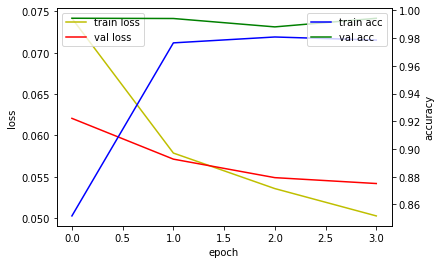

In [ ]:
acc_loss_plot(hist_1)

## model_2 (GRU+CNN)

In [ ]:
def model_GRU(num_classes):
    inp = Input(shape = (maxlen, ))
    layer = Embedding(max_words, 
                      embedding_dim,
                      weights = [embedding_matrix],
                      trainable=False)(inp)
    layer = Conv1D(32, 5, padding='same', activation='relu')(layer)
    layer = MaxPooling1D(3)(layer)
    later = Conv1D(32, 5, padding='same', activation='relu')(layer)
    layer = GRU(32, dropout=0.1, recurrent_dropout=0.5)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [ ]:
model_2 = model_GRU(num_classes)
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          2500000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 32)           16032     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 66, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 2,522,566
Trainable params: 22,566
Non-trainable params: 2,500,000
____________________________________________

In [ ]:
hist_2 = model_2.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/10
998/998 [==============================] - 167s 165ms/step - loss: 0.1977 - accuracy: 0.9771 - val_loss: 0.0661 - val_accuracy: 0.9856
Epoch 2/10
998/998 [==============================] - 165s 165ms/step - loss: 0.0640 - accuracy: 0.9819 - val_loss: 0.0585 - val_accuracy: 0.9728
Epoch 3/10
998/998 [==============================] - 165s 165ms/step - loss: 0.0563 - accuracy: 0.9742 - val_loss: 0.0568 - val_accuracy: 0.9689
Epoch 4/10
998/998 [==============================] - 165s 165ms/step - loss: 0.0543 - accuracy: 0.9802 - val_loss: 0.0565 - val_accuracy: 0.9897
Epoch 5/10
998/998 [==============================] - 166s 166ms/step - loss: 0.0524 - accuracy: 0.9789 - val_loss: 0.0547 - val_accuracy: 0.9856
Epoch 6/10
998/998 [==============================] - 165s 165ms/step - loss: 0.0504 - accuracy: 0.9810 - val_loss: 0.0554 - val_accuracy: 0.9899
Epoch 7/10
998/998 [==============================] - 166s 166ms/step - loss: 0.0482 - accuracy: 0.9816 - val_loss: 0.0532 -

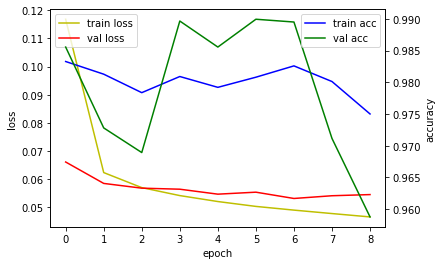

In [ ]:
acc_loss_plot(hist_2)

## model_3 (Bidirectional LSTM)

In [34]:
def model_LSTM(num_classes):
    inp = Input(shape = (maxlen, ))
    layer = Embedding(max_words, 
                      embedding_dim,
                      weights = [embedding_matrix],
                      trainable=False)(inp)
    layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(50, activation = 'relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [35]:
model_3 = model_LSTM(num_classes)
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 100)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 100)          60400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [36]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', patience = 3)
hist_3 = model_3.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.2, callbacks = [early_stop])

Epoch 1/10
998/998 [==============================] - 1688s 2s/step - loss: 0.1391 - accuracy: 0.6688 - val_loss: 0.0569 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 1691s 2s/step - loss: 0.0590 - accuracy: 0.9675 - val_loss: 0.0526 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 1686s 2s/step - loss: 0.0547 - accuracy: 0.9726 - val_loss: 0.0502 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 1684s 2s/step - loss: 0.0526 - accuracy: 0.9723 - val_loss: 0.0493 - val_accuracy: 0.9941
Epoch 5/10
998/998 [==============================] - 1694s 2s/step - loss: 0.0495 - accuracy: 0.9809 - val_loss: 0.0483 - val_accuracy: 0.9940
Epoch 6/10
998/998 [==============================] - 1691s 2s/step - loss: 0.0479 - accuracy: 0.9790 - val_loss: 0.0475 - val_accuracy: 0.9940
Epoch 7/10
998/998 [==============================] - 1690s 2s/step - loss: 0.0462 - accuracy: 0.9660 - val_loss: 0.0474 - val_accuracy:

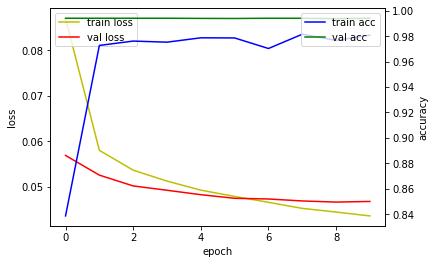

In [37]:
acc_loss_plot(hist_3)

# submit

In [38]:
test_x = list(test_x)

In [39]:
test_x[:10]

["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
 '== From RfC == \n\n The title is fine as it is, IMO.',
 '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "',
 ":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.",
 "I don't anonymously edit articles at all.",
 'Thank you for understanding. I think very highly of you and would not revert without discussion.',
 'Please do not add nonsense to Wikipedia. Such edits are considered vandalism and quickly undone. If you would like to experiment, please use the sand

In [40]:
texts_test = [] 

for line in tqdm(test_x, total=test.shape[0]): 
    texts_test.append(clean_text(line))

100%|██████████| 153164/153164 [00:17<00:00, 8749.77it/s]


In [41]:
test_x = [] 

for line in tqdm(texts_test, total=test.shape[0]): 
    test_x.append(clean_text_ab(line))

100%|██████████| 153164/153164 [00:11<00:00, 13730.95it/s]


In [42]:
sequences_test = tokenizer.texts_to_sequences(test_x)
padded_sequences_test = pad_sequences(sequences_test, maxlen = maxlen, padding = 'post')

In [ ]:
# Prediction for test data
predict_1 = model_1.predict(padded_sequences_test)
predict_2 = model_2.predict(padded_sequences_test)
predict_3 = model_3.predict(padded_sequences_test)

In [43]:
predict_3 = model_3.predict(padded_sequences_test)

In [ ]:
sub_c =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")
sub_g =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")
sub_b =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")

In [44]:
sub_b =  pd.read_csv("/content/drive/MyDrive/Parrot_teamproject/sample_submission.csv")

In [ ]:
sub_c.iloc[:,1:] = predict_1
sub_g.iloc[:,1:] = predict_2
sub_b.iloc[:,1:] = predict_3

In [45]:
sub_b.iloc[:,1:] = predict_3

In [ ]:
sub_c.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.986894,2.702895e-01,0.898328,1.897537e-01,0.833545,0.370285
1,0000247867823ef7,0.005081,2.640738e-05,0.001127,3.413223e-05,0.000715,0.000081
2,00013b17ad220c46,0.002518,1.764908e-05,0.000711,1.023051e-05,0.000345,0.000033
3,00017563c3f7919a,0.000371,4.498293e-08,0.000049,6.784263e-07,0.000028,0.000004
4,00017695ad8997eb,0.003625,6.780299e-06,0.000672,1.444483e-05,0.000423,0.000040


In [ ]:
sub_g.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.985209,0.165119,0.910472,0.042103,0.867803,0.167004
1,0000247867823ef7,0.003574,0.000058,0.000900,0.000086,0.000440,0.000074
2,00013b17ad220c46,0.003009,0.000044,0.000868,0.000058,0.000374,0.000060
3,00017563c3f7919a,0.000807,0.000017,0.000263,0.000030,0.000128,0.000027
4,00017695ad8997eb,0.006044,0.000084,0.001650,0.000103,0.000723,0.000093


In [46]:
sub_b.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.993998,2.332519e-01,0.928211,2.691716e-02,0.850077,4.048867e-01
1,0000247867823ef7,0.001065,1.887869e-07,0.000115,5.308029e-07,0.000063,3.444877e-06
2,00013b17ad220c46,0.002007,1.530218e-06,0.000350,3.437149e-06,0.000214,1.697906e-05
3,00017563c3f7919a,0.000231,2.498001e-08,0.000026,7.931759e-08,0.000011,3.989564e-07
4,00017695ad8997eb,0.002454,9.715272e-07,0.000265,2.567149e-06,0.000190,1.389609e-05


In [ ]:
sub_c.to_csv('/content/drive/MyDrive/Parrot/toxic_re_0407_1.csv', index=False)

In [ ]:
sub_g.to_csv('/content/drive/MyDrive/Parrot/toxic_re_0407_2.csv', index=False)

In [47]:
sub_b.to_csv('/content/drive/MyDrive/Parrot/toxic_re_0409_3.csv', index=False)

In [48]:
model_3.save('/content/drive/MyDrive/Parrot/toxic_re_0409_3.h5')